In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datetime import datetime
import PIL

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=200),
        transforms.RandomAffine(degrees=40,translate=(0.2,0.2), shear=0.2, fillcolor=0),
        transforms.CenterCrop(size=150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

test_transform = transforms.Compose([
        transforms.CenterCrop(size=150),
        transforms.ToTensor(),
])

In [ ]:
train_dataset = datasets.ImageFolder(
    '/content/drive/My Drive/Cats_vs_Dogs/train/',
    transform=train_transform
)
test_dataset = datasets.ImageFolder(
    '/content/drive/My Drive/Cats_vs_Dogs/validation/',
    transform=test_transform
)

In [ ]:
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = batch_size,
                                              shuffle=False)

In [ ]:
class CNN(nn.Module):
  def __init__(self,K):
    super(CNN,self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32,64,kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64,128,kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(128,128,kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    self.fc1 = nn.Linear(128*7*7,512)
    self.fc2 = nn.Linear(512,K)

  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
K = len(set(train_dataset.targets))
model = CNN(K)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(model)

cuda:0
CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.0001)

In [ ]:
model.to(device)
n_epochs = 30

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss=[]
  t0 = datetime.now()
  for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    # targets = targets.to(torch.float32)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs,targets)

    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
  train_loss = np.mean(train_loss)

  test_loss=[]
  for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    # targets = targets.to(torch.float32)
    outputs = model(inputs)
    loss = criterion(outputs,targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss

  dt = datetime.now() - t0
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

Epoch 1/30, Train Loss: 0.6940,       Test Loss: 0.6930, Duration: 0:15:39.077737
Epoch 2/30, Train Loss: 0.6926,       Test Loss: 0.6914, Duration: 0:00:16.589047
Epoch 3/30, Train Loss: 0.6899,       Test Loss: 0.6943, Duration: 0:00:16.517279
Epoch 4/30, Train Loss: 0.6871,       Test Loss: 0.6765, Duration: 0:00:16.479754
Epoch 5/30, Train Loss: 0.6721,       Test Loss: 0.6682, Duration: 0:00:16.477744
Epoch 6/30, Train Loss: 0.6723,       Test Loss: 0.6669, Duration: 0:00:16.572171
Epoch 7/30, Train Loss: 0.6603,       Test Loss: 0.6632, Duration: 0:00:16.460468
Epoch 8/30, Train Loss: 0.6576,       Test Loss: 0.6668, Duration: 0:00:16.467478
Epoch 9/30, Train Loss: 0.6613,       Test Loss: 0.6546, Duration: 0:00:16.454106
Epoch 10/30, Train Loss: 0.6483,       Test Loss: 0.6519, Duration: 0:00:16.392597
Epoch 11/30, Train Loss: 0.6554,       Test Loss: 0.6527, Duration: 0:00:16.363988
Epoch 12/30, Train Loss: 0.6526,       Test Loss: 0.6520, Duration: 0:00:16.311425
Epoch 13/30, 

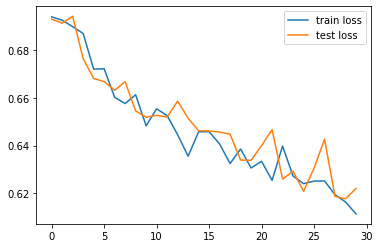

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total =0

train_acc=0
for inputs, targets in train_dataloader:
  inputs, targets = inputs.to(device),targets.to(device)
  targets = targets.to(torch.float32)

  outputs = model(inputs)
  try:
    _,prediction = torch.max(outputs,1)
  except Exception as e:
    print(e)
    print(output)
  n_correct += (prediction==targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct=0.
n_total=0.
for inputs, targets in test_dataloader:
  inputs,targets = inputs.to(device),targets.to(device)

  outputs = model(inputs)
  try:
    _,prediction = torch.max(outputs,1)
  except Exception as e:
    print(e)
    print(output)

  n_correct += (prediction==targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.6555, Test acc: 0.6690


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[407  93]
 [238 262]]


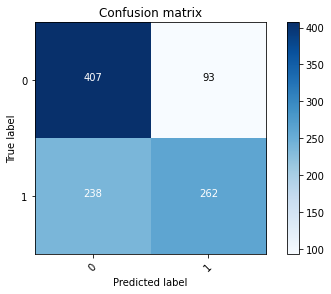

In [ ]:
y_test = test_dataset.targets

p_test = np.array([])
for inputs, targets in test_dataloader:
  # move data to GPU
  inputs = inputs.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(2)))